**Imports and Cuda**

In [1]:
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Numpy
import numpy as np
import pandas as pd
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**DATASET**

In [3]:
data_dir = 'chest_xray'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

img_height, img_width = 224, 224
batch_size = 32

# Data augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
validation_dataset = ImageFolder(root=val_dir, transform=test_transforms)
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

# Create dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Access class labels
class_labels = train_dataset.class_to_idx
print("Class Labels:", class_labels)

class_counts = {}
for _, labels in test_loader:
    for label in labels.cpu().numpy():
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

print("\nTesting Train DataLoader:")
for inputs, labels in train_loader:
    print('Inputs batch shape:', inputs.shape)
    print('Labels batch shape:', labels.shape)
    break;

print("\nTesting Validation DataLoader:")
for inputs, labels in validation_loader:
    print('Inputs batch shape:', inputs.shape)
    print('Labels batch shape:', labels.shape)
    break;

print("\nTesting Test DataLoader:")
for inputs, labels in test_loader:
    print('Inputs batch shape:', inputs.shape)
    print('Labels batch shape:', labels.shape)
    break;

Class Labels: {'NORMAL': 0, 'PNEUMONIA': 1}

Testing Train DataLoader:
Inputs batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])

Testing Validation DataLoader:
Inputs batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])

Testing Test DataLoader:
Inputs batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


**DEFINING MODEL**

In [5]:
model = models.efficientnet_b5(pretrained=True)
num_epochs = 15

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer for your 3 classes
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_labels))

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer (only train the last layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001, weight_decay=1e-5)

print(model)

c:\Users\khair\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\khair\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

**FIRST TRAINING LOOP**

In [ ]:
best_val_loss = float('inf')
counter = 0
patience=3

for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

        epoch_val_loss = validation_loss / len(validation_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth') #save best model
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

    # Load the best model state
model.load_state_dict(torch.load('best_model.pth'))


model.eval()
correct = 0
total = 0
with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total}%')

print("Training and Evaluation Complete.")

**LOAD MODEL AFTER TRAINING IN CASE OF EARLY LOSS**

In [ ]:
# Load the state dictionary
state_dict = torch.load('best_model.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

**UNFREEZE MORE LAYERS**

In [ ]:
for param in model.features[4:].parameters(): # unfreeze the last few blocks.
    param.requires_grad = True

# Modify the optimizer to include the unfreezed layers.
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-5) #lower learning rate.

**SECOND TRAINING LOOP**

In [ ]:
def fine_tune_with_history(model, criterion, optimizer, train_loader, validation_loader, test_loader, device, num_epochs=15, patience=3):

    best_val_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fine-tuning Loss (2nd Phase): {epoch_loss:.4f}")

        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

        epoch_val_loss = validation_loss / len(validation_loader)
        history['val_loss'].append(epoch_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Fine-tuning Validation Loss (2nd Phase): {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_fine_tuned_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(torch.load('best_fine_tuned_model.pth'))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Fine-tuning Accuracy (2nd Phase) of the model on the test images: {100 * correct / total}%')
    print("Fine-tuning (2nd Phase) and Evaluation Complete.")

    return model, history

Epoch 1/10, Loss: 0.27183207650126123
Epoch 1/10, Validation Loss: 0.47770872712135315
Epoch 2/10, Loss: 0.2702770834685835
Epoch 2/10, Validation Loss: 0.4555993378162384
Epoch 3/10, Loss: 0.26421150354885614
Epoch 3/10, Validation Loss: 0.46674463152885437
Epoch 4/10, Loss: 0.26321182669671767
Epoch 4/10, Validation Loss: 0.4396243691444397
Epoch 5/10, Loss: 0.2618339180580677
Epoch 5/10, Validation Loss: 0.4072030484676361
Epoch 6/10, Loss: 0.26573812467920266
Epoch 6/10, Validation Loss: 0.40163087844848633
Epoch 7/10, Loss: 0.25750434234098424
Epoch 7/10, Validation Loss: 0.45139262080192566
Epoch 8/10, Loss: 0.25203151360976916
Epoch 8/10, Validation Loss: 0.4364386796951294
Epoch 9/10, Loss: 0.26137008353427876
Epoch 9/10, Validation Loss: 0.3649381399154663
Epoch 10/10, Loss: 0.2591705071779848
Epoch 10/10, Validation Loss: 0.3865150213241577
Accuracy of the model on the test images: 84.2948717948718%
Training and Evaluation Complete.


In [ ]:
def evaluate_and_visualize(model, test_loader, device, class_names, history=None, train_loader=None, class_labels=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

    # Plotting Training History (Loss)
    if history:
        plt.figure(figsize=(8, 5))
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    # Plotting Class Distribution (Training Set)
    if train_loader and class_labels: #ensure both are passed.
        class_counts = {}
        for _, labels in train_loader:
            for label in labels:
                label_item = label.item()
                if label_item not in class_counts:
                    class_counts[label_item] = 0
                class_counts[label_item] += 1

        counts = [class_counts.get(class_labels[name], 0) for name in class_names]

        plt.figure(figsize=(10, 6))
        plt.bar(class_names, counts)
        plt.xlabel('Classes')
        plt.ylabel('Count')
        plt.title('Class Distribution in Training Set')
        plt.xticks(rotation=45)
        plt.show()

In [22]:
model, history = fine_tune_with_history(model, criterion, optimizer, train_loader, validation_loader, test_loader, device, num_epochs=15, patience=3)

Epoch 1/15, Fine-tuning Loss (2nd Phase): 0.1131
Epoch 1/15, Fine-tuning Validation Loss (2nd Phase): 0.1192
Epoch 2/15, Fine-tuning Loss (2nd Phase): 0.1105
Epoch 2/15, Fine-tuning Validation Loss (2nd Phase): 0.1281
Epoch 3/15, Fine-tuning Loss (2nd Phase): 0.1157
Epoch 3/15, Fine-tuning Validation Loss (2nd Phase): 0.1364
Epoch 4/15, Fine-tuning Loss (2nd Phase): 0.1089
Epoch 4/15, Fine-tuning Validation Loss (2nd Phase): 0.1260
Early stopping!
Fine-tuning Accuracy (2nd Phase) of the model on the test images: 93.58974358974359%
Fine-tuning (2nd Phase) and Evaluation Complete.


**EVALUATE AND VISUALISE**

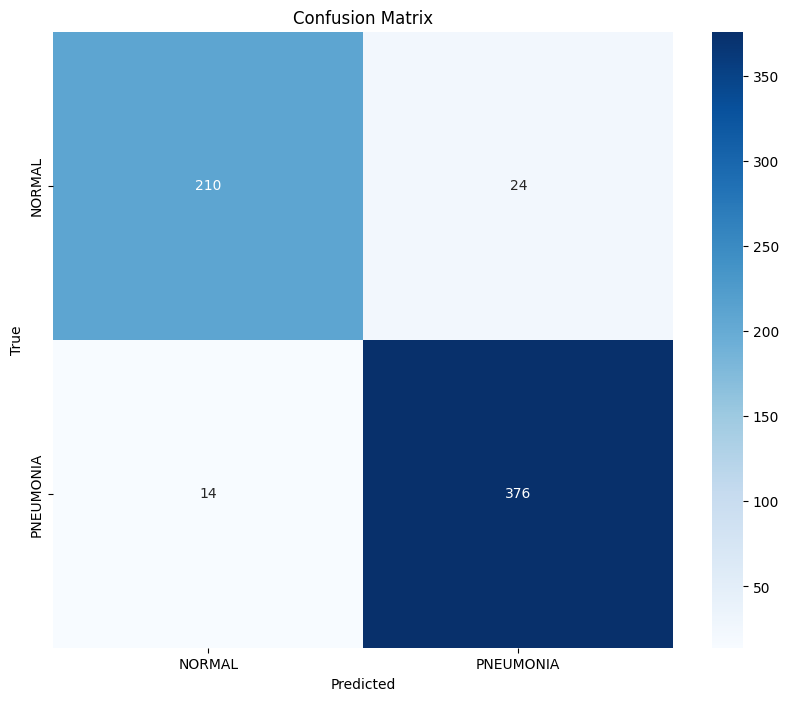

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.94      0.90      0.92       234
   PNEUMONIA       0.94      0.96      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



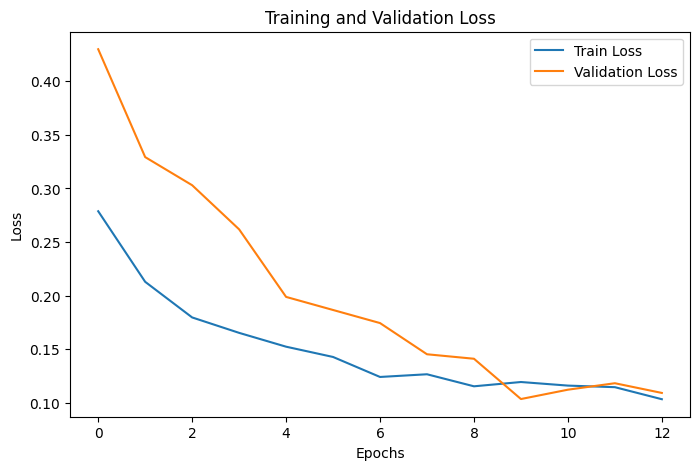

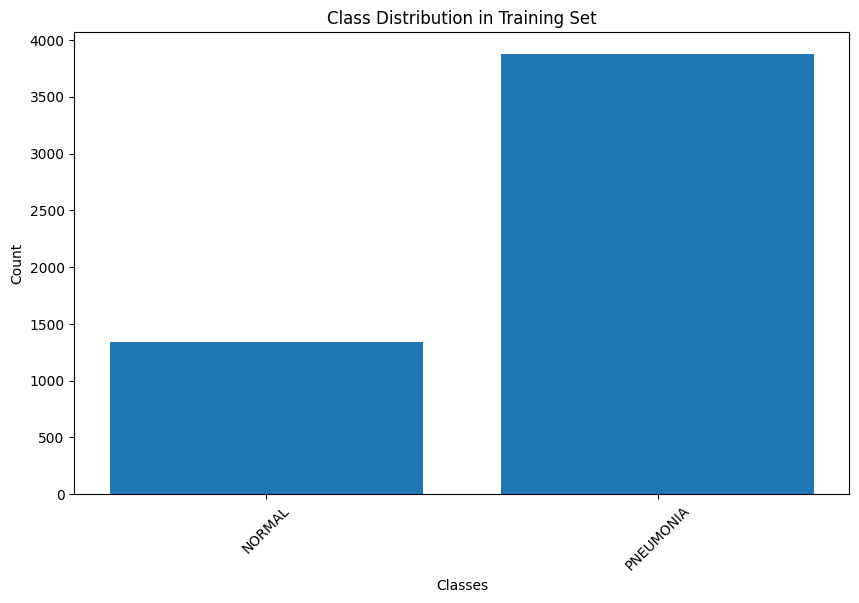

In [15]:
evaluate_and_visualize(model, test_loader, device, list(train_dataset.class_to_idx.keys()), history, train_loader, train_dataset.class_to_idx)